In [2]:
#############################################
# This will plot all dice positions, in 3D. #
#############################################

import json
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.patches as mpatches
from tqdm import tqdm
from typing import Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
LOG_FILE_NAME = "model_dice.log"
REFETCH_DATA = False
BATCH_SIZE = 2
TEST_SAVE_REP = 1 # The lower the more we'll test each batch size
EPOCHS = 20
LEARNING_RATE = 0.005

In [4]:
# GPU Section
print(f"You have {torch.cuda.device_count()} GPU(s).")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU.")
else:
    device = torch.device("cpu")
    print("Running on CPU.")

You have 0 GPU(s).
Running on CPU.


In [5]:
def normalize(data):
    input, output = data['input'], data['output']
    x, y, z = input['x'], input['y'], input['z']

    # normalizing
    x = (x + np.pi) / (2 * np.pi)
    y = (y + np.pi) / (2 * np.pi)
    z = (z + np.pi) / (2 * np.pi)

    x_y_z = np.array([x, y, z])
    one_hot = np.eye(6)[output[0]-1]
    return [ x_y_z, one_hot ]

class Data():
    dir_ = "dice_training_data.json"
    training_data = []

    def load_data(self):
        f = open(self.dir_)
        file = json.load(f)
        for i in file:
            self.training_data.append([ normalize(i) ])

        np.random.shuffle(self.training_data)
        np.save("training_data_dice.npy", np.array(self.training_data, dtype=object))
        
        f.close()

# Getting our data
if REFETCH_DATA:
    data = Data()
    data.load_data()
    training_data = data.training_data
else:
    training_data = np.load("training_data_dice.npy", allow_pickle=True)

print(len(training_data))

300


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3 , 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 6 )
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

# Connecting The NN To The GPU
net = Net().to(device)
print(net)

# Optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
loss_function = nn.MSELoss()

# Our X, y data
X = torch.Tensor([i[0] for i in training_data]).reshape(-1, 1, 3)
y = torch.Tensor([i[1] for i in training_data])

# Training and testing cutoff point
test_train_idx = int(len(X) * 0.1)

# Training data
train_X = X[:-test_train_idx].reshape(-1, 3)
train_y = y[:-test_train_idx]

# Testing data
test_X = X[-test_train_idx:]
test_y = y[-test_train_idx:]

print(len(train_X))
print(len(test_X))

Net(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)
270
30


/tmp/ipykernel_23188/3435830279.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X = torch.Tensor([i[0] for i in training_data]).reshape(-1, 1, 3)


In [7]:
def fwd_pass(X: torch.Tensor, y: torch.Tensor, train=False) -> Tuple[float, float]:
    X = X.reshape(-1, 3).to(device)
    y = y.to(device)

    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True) / len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()
    
    return acc, float(loss)

In [8]:
def test(size=32) -> Tuple[float, float]:
    start = np.random.randint(len(test_X) - size)
    X, y = test_X[start:start+size], test_y[start:start+size]
    val_acc, val_loss = fwd_pass(X, y)
    return val_acc, val_loss

In [9]:
MODEL_NAME = f"model-{round(time.time())}"
print(MODEL_NAME)

# Optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
loss_function = nn.MSELoss()

def train() -> Tuple[float, torch.Tensor]:
    with open(LOG_FILE_NAME, "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE]
                batch_y = train_y[i:i+BATCH_SIZE]
                
                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                if i % TEST_SAVE_REP == 0:
                    val_acc, val_loss = test(size=2)
                    f.write(f"{MODEL_NAME},{round(time.time(), 3)},{round(acc, 2)},{round(loss, 4)},{round(val_acc, 2)},{round(val_loss, 4)}\n")
        f.close()

train()

model-1679639340


100%|██████████| 135/135 [00:00<00:00, 1239.66it/s]


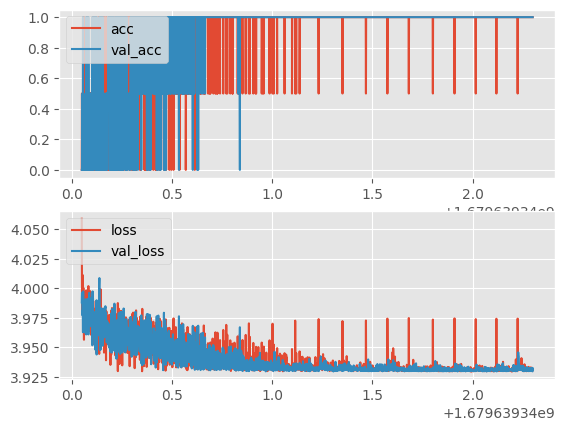

In [10]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

model_name = MODEL_NAME

def create_acc_loss_graph(model_name):
    contents = open(LOG_FILE_NAME, "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    # fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0))
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()

create_acc_loss_graph(model_name)

In [11]:
torch.save(net.state_dict(), "dice_ai.pth")

In [12]:
d1 = {
  "input": {
    "x": -1.5710773661433908,
    "y": 0.0021407744273951226,
    "z": 2.214420626870026
  },
  "output": [
    3
  ]
}
d2 = {
  "input": {
    "x": -3.137269887546084,
    "y": 0.7568137426227949,
    "z": 3.1338692108445003
  },
  "output": [
    1
  ]
}

tensor = normalize(d2)[0]
print(tensor)

out = torch.Tensor(tensor).view(-1, 3)
out = net(out).to(device)
out = torch.exp(out)
out = int(torch.argmax(out)) + 1
print("\nComputer thinks it's a", out)

[6.87989584e-04 6.20450648e-01 9.98770776e-01]

Computer thinks it's a 3
